In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
#import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "../dataset/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:24<00:00,  5.11it/s]


In [3]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [4]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [5]:
# Get the answers
answers = []
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_answers = []
    for conv in convos:
        if conv["role"] == "assistant":
            answers.append(conv["text"])
            user_answers.append(conv["text"])
    code2answers[code] = user_answers

In [6]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [7]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
#####################
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

Starting Pre-Processing

In [8]:
# Convert to lower case
code2prompts_proc = defaultdict(list)
def convert2lowercase(text):
    return text.lower()


for code, user_prompts in code2prompts.items():
    code2prompts_proc[code] = [convert2lowercase(text) for text in user_prompts]

prompts = [convert2lowercase(text) for text in prompts]
questions = [convert2lowercase(text) for text in questions]

In [9]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
import string

def remove_punc(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

for code, user_prompts in code2prompts_proc.items():
    code2prompts_proc[code] = [remove_punc(text) for text in user_prompts]

prompts = [remove_punc(text) for text in prompts]
questions = [remove_punc(text) for text in questions]

In [11]:
code2prompts_proc["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]

'load a csv file into a pandas in python the file is named cs412hw1datasetcsv and contains columns like species island sex diet year life stage body mass g bill length mm bill depth mm flipper length mm and health metrics \n'

In [12]:
# Tokenize the prompts
def tokenize(text):
    return word_tokenize(text)

for code, user_prompts in code2prompts_proc.items():
    code2prompts_proc[code] = [tokenize(text) for text in user_prompts]

prompts = [tokenize(text) for text in prompts]
questions = [tokenize(text) for text in questions]

In [13]:
code2prompts_proc["0031c86e-81f4-4eef-9e0e-28037abf9883"][0][:5]

['load', 'a', 'csv', 'file', 'into']

In [14]:
# Remove stop words
from nltk.corpus import stopwords

stopwordsList= set(stopwords.words('english'))

def remove_stopwords(tokenized_text):
    return [word for word in tokenized_text if word not in stopwordsList]

for code, user_prompts in code2prompts_proc.items():
    code2prompts_proc[code] = [remove_stopwords(text) for text in user_prompts]

prompts = [remove_stopwords(text) for text in prompts]
questions = [remove_stopwords(text) for text in questions]

In [15]:
print(code2prompts_proc["0031c86e-81f4-4eef-9e0e-28037abf9883"][0][:7])
print(questions[0][:7])

['load', 'csv', 'file', 'pandas', 'python', 'file', 'named']
['initialize', 'first', 'make', 'copy', 'notebook', 'given', 'starter']


In [16]:
# Apply Stemming
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

def stemming(tokenized_text):
    joined_text = ' '.join(tokenized_text)
    
    tokenized = word_tokenize(joined_text)
    
    stemmed = [stemmer.stem(word) for word in tokenized]
    return stemmed

for code, user_prompts in code2prompts_proc.items():
    code2prompts_proc[code] = [stemming(text) for text in user_prompts]

prompts = [stemming(text) for text in prompts]
questions = [stemming(text) for text in questions]

In [17]:
print(code2prompts_proc["0031c86e-81f4-4eef-9e0e-28037abf9883"][0][:7])
print(questions[0][:7])

['load', 'csv', 'file', 'panda', 'python', 'file', 'name']
['initi', 'first', 'make', 'copi', 'notebook', 'given', 'starter']


In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\salih\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize

# # Lemmatizer'ı başlat
# lemmatizer = WordNetLemmatizer()

# def lemmatize_text(tokenized_text):
#     joined_text = ' '.join(tokenized_text)
    
#     tokenized = word_tokenize(joined_text)
    
#     lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]
#     return lemmatized

# # Her bir metin üzerinde lemmatization uygula
# prompts = [lemmatize_text(text) for text in prompts]
# questions = [lemmatize_text(text) for text in questions]

In [20]:
print(code2prompts_proc["0031c86e-81f4-4eef-9e0e-28037abf9883"][0][:7])
print(questions[0][:7])

['load', 'csv', 'file', 'panda', 'python', 'file', 'name']
['initi', 'first', 'make', 'copi', 'notebook', 'given', 'starter']


In [21]:
def joinThemAll(tokenized_text):
    return ' '.join(tokenized_text)

for code, user_prompts in code2prompts_proc.items():
    code2prompts_proc[code] = [joinThemAll(text) for text in user_prompts]

prompts = [joinThemAll(text) for text in prompts]
questions = [joinThemAll(text) for text in questions]

In [22]:
print(code2prompts_proc["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])
print(questions[0])

load csv file panda python file name cs412hw1datasetcsv contain column like speci island sex diet year life stage bodi mass g bill length mm bill depth mm flipper length mm health metric
initi first make copi notebook given starter make sure choos connect form upper right may upload data section left colab right click csv file get path file click copi path use load data


In [23]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=2000)
vectorizer = vectorizer.fit(prompts + questions)

In [24]:
# Bag of Words Approach

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_BoW = CountVectorizer(ngram_range=(1, 3), max_features=2000)
vectorizer_BoW = vectorizer_BoW.fit(prompts + questions)

In [25]:
# Word2Vec Approach

from gensim.models import Word2Vec
questions_and_prompts_and_answers = [sentence.split() for sentence in prompts + questions]

vector_size = 500               # These can be tuned
window = 5
min_count = 5

w2v_model = Word2Vec(
    questions_and_prompts_and_answers,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)


def vectorize(q_and_p_and_a, model):
    word_vectors = [model.wv[word] for word in q_and_p_and_a if word in model.wv]

    if not word_vectors:
        return np.zeros(model.vector_size)  # Return zero vector if no word vectors are found

    avg_vector = np.mean(word_vectors, axis=0)
    return avg_vector

c:\Users\salih\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [26]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00,0000750,0019261,0022867,0040724,0053031,0053031 diet,0053031 diet 0172632,0056337,0091418,...,year year data,ypred,ytest,ytest traintestsplitx,ytest traintestsplitx testsize02,ytrain,ytrain fitparam,ytrain fitparam file,ytrain ytest,ytrain ytest traintestsplitx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Bag of Words Approach

questions_BoW = pd.DataFrame(vectorizer_BoW.transform(questions).toarray(), columns=vectorizer_BoW.get_feature_names_out())
questions_BoW.head()

,00,0000750,0019261,0022867,0040724,0053031,0053031 diet,0053031 diet 0172632,0056337,0091418,...,year year data,ypred,ytest,ytest traintestsplitx,ytest traintestsplitx testsize02,ytrain,ytrain fitparam,ytrain fitparam file,ytrain ytest,ytrain ytest traintestsplitx
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Word2Vec Approach

questions_w2v = pd.DataFrame([vectorize(sentence, w2v_model) for sentence in questions], columns=[f'w2v_{i}' for i in range(vector_size)])
questions_w2v.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_490,w2v_491,w2v_492,w2v_493,w2v_494,w2v_495,w2v_496,w2v_497,w2v_498,w2v_499
0,0.029972,0.045534,0.049809,0.066545,0.004587,-0.110706,-0.036106,0.078909,0.040490,0.008208,...,-0.017383,-0.005955,0.068371,-0.018757,0.045803,-0.007184,-0.017321,-0.052923,-0.036275,-0.031403
1,-0.000694,0.089657,0.123009,0.094720,-0.017756,-0.146363,-0.026715,0.093927,0.051261,0.044753,...,-0.039936,-0.015904,0.098353,0.028946,0.040916,-0.045497,-0.091724,-0.095341,-0.034754,-0.028881
2,0.031946,0.064826,0.079446,0.076708,-0.008920,-0.113357,-0.018778,0.097024,0.057171,0.027077,...,-0.014060,-0.013308,0.083069,-0.003804,0.046198,-0.011833,-0.037040,-0.079447,-0.043076,-0.039293
3,0.036537,0.110694,0.088087,0.101248,-0.059560,-0.078723,-0.011567,0.134007,0.054045,0.066014,...,0.019906,-0.018972,0.131860,0.041252,0.066043,0.047900,-0.007001,-0.113243,-0.084672,-0.024365
4,0.036859,0.045793,0.050028,0.069003,-0.002808,-0.099774,-0.021975,0.085661,0.046253,0.018967,...,-0.012211,-0.005503,0.065450,-0.012498,0.049643,0.000253,0.002531,-0.055839,-0.047054,-0.035431


In [29]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts_proc.items():
    # code = "0031c86e-81f4-4eef-9e0e-28037abf9883", user_prompts = [prompt1, prompt2, ...]
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [30]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00,0000750,0019261,0022867,0040724,0053031,0053031 diet,0053031 diet 0172632,0056337,0091418,...,year year data,ypred,ytest,ytest traintestsplitx,ytest traintestsplitx testsize02,ytrain,ytrain fitparam,ytrain fitparam file,ytrain ytest,ytrain ytest traintestsplitx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 2000)

In [32]:
# Bag of Words Approach

code2prompts_BoW = dict()
for code, user_prompts in code2prompts_proc.items():
    # code = "0031c86e-81f4-4eef-9e0e-28037abf9883", user_prompts = [prompt1, prompt2, ...]
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_BoW = pd.DataFrame(vectorizer_BoW.transform(user_prompts).toarray(), columns=vectorizer_BoW.get_feature_names_out())
    code2prompts_BoW[code] = prompts_BoW

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [33]:
# Word2Vec Approach

code2prompts_w2v = dict()

for code, user_prompts in code2prompts_proc.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue

    prompts_Word2Vec = pd.DataFrame([vectorize(sentence.split(), w2v_model) for sentence in user_prompts], columns=[f'w2v_{i}' for i in range(vector_size)])
    code2prompts_w2v[code] = prompts_Word2Vec

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [34]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [35]:
questions[4]

'featur correl 10 pts correl featur health 4 point calcul correl featur dataset highlight strong correl target variabl plot result heatmap featur select 3 point select subset featur like strong predictor justifi choic base comput correl hypothet driver featur 3 point propos two hypothet featur could enhanc model predict accuraci explain might deriv expect impact show result correl target variabl note get get help gpt'

In [36]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.112329,0.213899,0.431712,0.345116,0.478540,0.479824,0.075568,0.105612,0.044732
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.152252,0.794093,0.712662,0.838271,0.531717,0.957775,0.690658,0.578877,0.450405
2,041f950b-c013-409a-a642-cffff60b9d4b,0.080197,0.177811,0.435799,0.256042,0.610731,0.321699,0.333236,0.395504,0.213996
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.052040,0.077495,0.144057,0.213483,0.300573,0.211384,0.089002,0.148559,0.261288
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.379493,0.710085,0.720525,0.552641,0.625788,0.847184,0.597846,0.909293,0.374091
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.144183,0.116902,0.111659,0.081121,0.101969,0.425148,1.000000,0.986036,0.750460
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.140559,0.042723,0.194807,0.877265,0.712930,0.828748,0.173285,0.897551,0.498851
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.169098,0.957328,0.938875,0.927903,0.842885,0.908948,0.738339,0.811619,0.414540
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.169098,0.957328,1.000000,0.671533,0.966312,0.880253,1.000000,1.000000,0.726883


Applying PCA to Each of the Vectorizers and Examining the Explained Variance

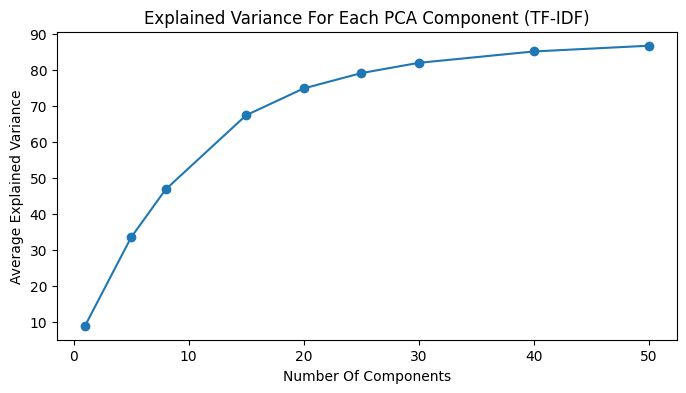

In [37]:
# Use PCA to TF-IDF vectorized prompts

from sklearn.decomposition import PCA
components = [1,5,8,15,20,25,30,40,50]
avg_exp_variances = []


for n in components:
    
    exp_variances = []
    for code, user_prompts_TF_IDF in code2prompts_tf_idf.items():
        pca = PCA(n_components = min(n, len(user_prompts_TF_IDF)), random_state=43)
        pca_df = pca.fit_transform(pd.concat([user_prompts_TF_IDF, questions_TF_IDF]))
        exp_variances.append(pca.explained_variance_ratio_.sum() * 100)

    avg_exp_variance = np.mean(exp_variances)
    avg_exp_variances.append(avg_exp_variance)
        
plt.figure(figsize=(8,4))
plt.plot(components, avg_exp_variances, marker='o')
plt.title('Explained Variance For Each PCA Component (TF-IDF)'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Average Explained Variance')
plt.show()

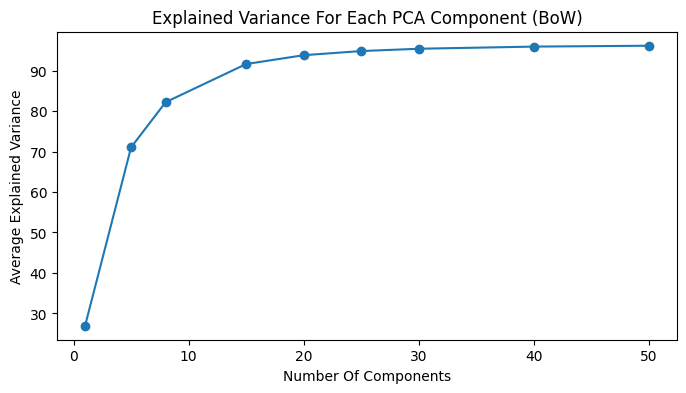

In [38]:
# Use PCA to BoW vectorized prompts

from sklearn.decomposition import PCA
components = [1,5,8,15,20,25,30,40,50]
avg_exp_variances = []


for n in components:
    exp_variances = []
    for code, user_prompts_BoW in code2prompts_BoW.items():
        pca = PCA(n_components = min(n, len(user_prompts_BoW)), random_state=43)
        pca_df = pca.fit_transform(pd.concat([user_prompts_BoW, questions_BoW]))
        exp_variances.append(pca.explained_variance_ratio_.sum() * 100)

    avg_exp_variance = np.mean(exp_variances)
    avg_exp_variances.append(avg_exp_variance)
        
plt.figure(figsize=(8,4))
plt.plot(components, avg_exp_variances, marker='o')
plt.title('Explained Variance For Each PCA Component (BoW)'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Average Explained Variance')
plt.show()

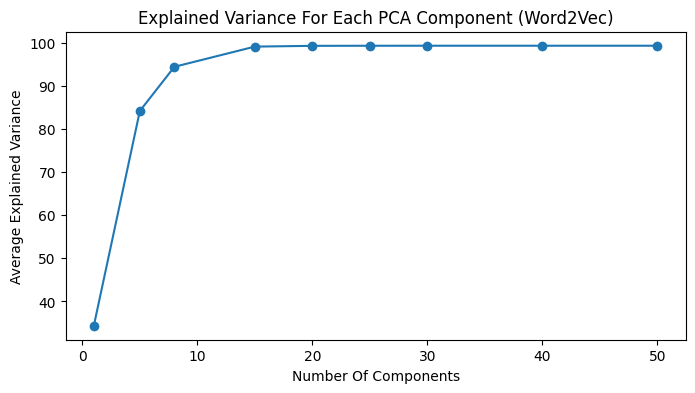

In [39]:
# Use PCA to word2vec vectorized prompts

from sklearn.decomposition import PCA
components = [1,5,8,15,20,25,30,40,50]
avg_exp_variances = []


for n in components:
    
    exp_variances = []
    for code, user_prompts_w2v in code2prompts_w2v.items():
        pca = PCA(n_components = min(n, len(user_prompts_w2v)), random_state=43)
        pca_df = pca.fit_transform(pd.concat([user_prompts_w2v, questions_w2v]))
        exp_variances.append(pca.explained_variance_ratio_.sum() * 100)

    avg_exp_variance = np.mean(exp_variances)
    avg_exp_variances.append(avg_exp_variance)
        
plt.figure(figsize=(8,4))
plt.plot(components, avg_exp_variances, marker='o')
plt.title('Explained Variance For Each PCA Component (Word2Vec)'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Average Explained Variance')
plt.show()

Select num_of_features of PCA as the one with higher than 80-90% explained variance.

In [40]:
# Use K-means clustering with TF-IDF vectorized prompts
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
for code, user_prompts_TF_IDF in code2prompts_tf_idf.items():
    # Combine user prompts tf-idf and questions tf-idf
    combined_data = pd.concat([user_prompts_TF_IDF, questions_TF_IDF])

    # Determine the number of components dynamically
    n_components = min(35, min(combined_data.shape))

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_df = pca.fit_transform(combined_data)
    pca_questions = pca_df[-len(questions):]

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=9, random_state=0, n_init=1, init=pca_questions).fit(pca_df)

    # Get the silhouette score
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette)

average_score = np.mean(scores)
print(f"Average Silhouette Score: {average_score}")

Average Silhouette Score: 0.13029217886733324


In [41]:
# Use K-means clustering with BoW vectorized prompts

scores = []

for code, user_prompts_BoW in code2prompts_BoW.items():
    # Combine user prompts BoW and questions BoW
    combined_data = pd.concat([user_prompts_BoW, questions_BoW])

    # Determine the number of components dynamically
    n_components = min(15, min(combined_data.shape))

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_df = pca.fit_transform(combined_data)
    pca_questions = pca_df[-len(questions):]

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=9, random_state=0, n_init=1, init=pca_questions).fit(pca_df)

    # Get the silhouette score
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette)

average_score = np.mean(scores)
print(f"Silhouette Score: {average_score}")

Silhouette Score: 0.2705258556938344


In [42]:
# Use K-means clustering with word2vec vectorized prompts

scores = []

for code, user_prompts_w2v in code2prompts_w2v.items():
    # Combine user prompts BoW and questions BoW
    combined_data = pd.concat([user_prompts_w2v, questions_w2v])

    # Determine the number of components dynamically
    n_components = min(10, min(combined_data.shape))

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_df = pca.fit_transform(combined_data)
    pca_questions = pca_df[-len(questions):]

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=9, random_state=0, n_init=1, init=pca_questions).fit(pca_df)

    # Get the silhouette score
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette)

average_score = np.mean(scores)
print(f"Silhouette Score: {average_score}")

Silhouette Score: 0.1037522123229451


We select BoW since it gives the highest silhouette score

Create the dataframe that keeps the question label for each prompt

In [43]:
code2plabels = {}           # code: [(p1, p1_label), (p2, p2_label), ...]

for code, user_prompts_BoW in code2prompts_BoW.items():
    # Combine user prompts BoW and questions BoW
    combined_data = pd.concat([user_prompts_BoW, questions_BoW])

    # Determine the number of components dynamically
    n_components = min(15, min(combined_data.shape))

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_df = pca.fit_transform(combined_data)
    pca_questions = pca_df[-len(questions):]

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=9, random_state=0, n_init=1, init=pca_questions).fit(pca_df)

    # Create a dataframe with the prompts and their labels
    prompts_df = pd.DataFrame({
        'Prompts':code2prompts[code],
        'Labels':kmeans.labels_[:-len(questions)]
                              })
    code2plabels[code] = prompts_df


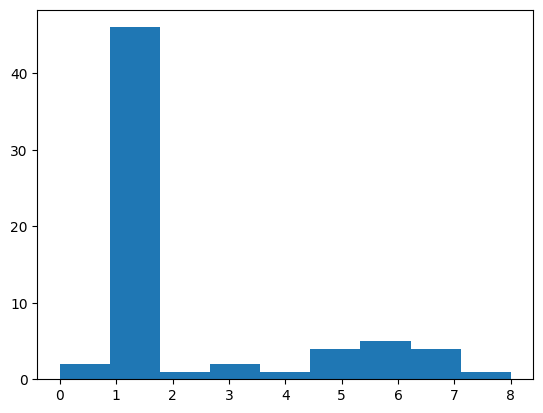

In [44]:
labels = code2plabels["6d5742c1-77c4-429c-8f6e-ef1262ca5557"]["Labels"].tolist()

plt.hist(labels, bins=9)
plt.show()

In [45]:
code2plabels["6d5742c1-77c4-429c-8f6e-ef1262ca5557"].head()

,Prompts,Labels
0,"Hi CHATGPT, together we are going to do Homewo...",1
1,Import necessary libraries,1
2,Load training dataset (5 pts)\n\n* Read the ....,1
3,I already have pandas,1
4,C:\Users\90537\OneDrive\MasaÃ¼stÃ¼\CS412\hw1\c...,1


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

### Sentiment Analysis

In [46]:
from transformers import pipeline
import numpy as np

# Load the sentiment-analysis pipeline with BERT model
bert_sentiment = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment_bert(prompts):
    polarities = []
    for prompt in prompts:
        # Handle long texts by splitting into smaller chunks
        prompt_parts = [prompt[i:i+512] for i in range(0, len(prompt), 512)]
        for part in prompt_parts:
            result = bert_sentiment(part)[0]
            polarity = 1 if result['label'] == 'POSITIVE' else -1
            polarities.append(polarity * result['score'])
    return np.mean(polarities) if polarities else 0
    
# Assuming code2prompts is defined with your prompts
# Calculate average sentiment score for each key using BERT
bert_average_sentiments = {key: analyze_sentiment_bert(prompts) for key, prompts in code2prompts.items()}

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


### Get Average Sentiment for Each User

In [47]:
from textblob import TextBlob

def analyze_sentiment_blob(text):
    return TextBlob(text).sentiment

# Apply sentiment analysis
sentiments = {key: [analyze_sentiment_blob(prompt) for prompt in prompts] for key, prompts in code2prompts.items()}

sentiments["6d5742c1-77c4-429c-8f6e-ef1262ca5557"]

[Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=1.0),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=-0.16666666666666666, subjectivity=0.4861111111111111),
 Sentiment(polarity=0.0, subjectivity=0.06388888888888888),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=0.06666666666666667),
 Sentiment(polarity=-0.125, subjectivity=0.375),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.13636363636363635, subjectivity=0.45454545454545453),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=0.0, subjectivity=0.0),
 Sentiment(polarity=-0.049999999999999996, subjectivity=0.5785714285714285),
 Sentiment(polarity=0.2611111111111111, subjectivity=0.5907407407407407),


In [48]:
# Calculate average sentiment score for each key
average_sentiment_scores = {}
for key, sentiment_list in sentiments.items():
    # Calculate average polarity
    average_polarity = sum(sentiment.polarity for sentiment in sentiment_list) / len(sentiment_list) if sentiment_list else 0
    average_sentiment_scores[key] = average_polarity

# average_sentiment_scores now contains the average sentiment score for each key
# print(average_sentiment_scores)

### Calculating Readability Score

In [49]:
import textstat

def calculate_readability_scores(text):
    scores = {}
    scores['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
    scores['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
    scores['gunning_fog'] = textstat.gunning_fog(text)
    scores['smog_index'] = textstat.smog_index(text)
    scores['automated_readability_index'] = textstat.automated_readability_index(text)
    scores['coleman_liau_index'] = textstat.coleman_liau_index(text)
    scores['linsear_write_formula'] = textstat.linsear_write_formula(text)
    scores['dale_chall_readability_score'] = textstat.dale_chall_readability_score(text)
    return scores

print(calculate_readability_scores("This is a sample sentence. It is very easy to read.").values())

dict_values([99.73, 0.7, 2.2, 0.0, -1.2, -0.55, 1.75, 5.34])


In [50]:
code2features = defaultdict(lambda : defaultdict(int))

# For each user
for code, convs in code2convos.items():
    totalNumWords = 0
    if len(convs) == 0:
        print(code)
        continue
    # For each prompt
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            code2features[code]["prompt_avg_words"] += len(text.split())
            totalNumWords += len(text.split())
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_words"] += len(text.split())

        code2features[code]["response_avg_words"] /= code2features[code]["#user_prompts"]
        code2features[code]["prompt_avg_words"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [51]:
# Whitelist_score = (q1_whitelistwords * q1_weight + q2_whitelistwords * q2_weight + ...) / total_weight

whiteListWords = ["thank", "next", "entropy", "correct", "solve", "hypothetical", "feature", "gini"]
blackListWords = ["not", "no", "error", "but", "issue", "problem", "bug", "wrong", "fail"]

def find_whitelist_words(text):
    return sum([1 if word in whiteListWords else 0 for word in text.split()]) / len(text.split())

def find_blacklist_words(text):
    return sum([1 if word in blackListWords else 0 for word in text.split()]) / len(text.split())

# Calculate the frequency of whitelist/blacklist words in each prompt

question_scores = [0, 5, 15, 5, 10, 20, 15, 20, 10]
for code in code2plabels.keys():
    values = {}             # {q1_whitelistwords: 0.5, q1_blacklistwords: 0.2, ...}
    for q in code2plabels[code]["Labels"].unique():
        values[f"q{q+1}_whitelist"] = code2plabels[code][code2plabels[code]["Labels"] == q][["Prompts"]].applymap(find_whitelist_words).mean().values[0]
        values[f"q{q+1}_blacklist"] = code2plabels[code][code2plabels[code]["Labels"] == q][["Prompts"]].applymap(find_blacklist_words).mean().values[0]

    # Calculate the weighted average of whitelist/blacklist words
    weight_total = 0
    whitelist_score = 0
    blacklist_score = 0
    for q in code2plabels[code]["Labels"].unique():
        weight_total += question_scores[q]
        whitelist_score += values[f"q{q+1}_whitelist"] * question_scores[q]
        blacklist_score += values[f"q{q+1}_blacklist"] * question_scores[q]
    
    whitelist_score /= weight_total
    blacklist_score /= weight_total
    
    code2features[code]["whitelist_score"] = whitelist_score * 100
    code2features[code]["blacklist_score"] = blacklist_score * 100

In [52]:
# Assuming code2features is defined as shown earlier
# And average_sentiment_scores is the dictionary with average sentiment scores

# Add average sentiment score to each key in code2features
for key in code2features.keys():
    # Check if the key exists in average_sentiment_scores
    if key in average_sentiment_scores:
        code2features[key]['average_sentiment'] = average_sentiment_scores[key]
    else:
        # If the key doesn't exist in average_sentiment_scores, set a default value
        code2features[key]['average_sentiment'] = 0  # or any other appropriate default value

for key in code2features.keys():
     # Check if the key exists in average_sentiment_scores
    if key in bert_average_sentiments:
        code2features[key]['bert_average_sentiment'] = bert_average_sentiments[key]
    else:
        # If the key doesn't exist in average_sentiment_scores, set a default value
        code2features[key]['bert_average_sentiment'] = 0  # or any other appropriate default value

In [53]:
# Add readability scores to each key in code2features


for code, prompts in code2prompts.items():
    avg_scores = np.zeros(8)
    length = len(prompts)
    for prompt in prompts:
        scores = np.array(list(calculate_readability_scores(prompt).values()))
        avg_scores += scores
        
    avg_scores /= length
    code2features[code]["flesch_reading_ease"] = avg_scores[0]
    code2features[code]["flesch_kincaid_grade"] = avg_scores[1]
    code2features[code]["gunning_fog"] = avg_scores[2]
    code2features[code]["smog_index"] = avg_scores[3]
    code2features[code]["automated_readability_index"] = avg_scores[4]
    code2features[code]["coleman_liau_index"] = avg_scores[5]
    code2features[code]["linsear_write_formula"] = avg_scores[6]
    code2features[code]["dale_chall_readability_score"] = avg_scores[7]

C:\Users\salih\AppData\Local\Temp\ipykernel_3008\2005071228.py:11: RuntimeWarning: invalid value encountered in divide
  avg_scores /= length


In [54]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,prompt_avg_words,response_avg_words,whitelist_score,blacklist_score,average_sentiment,bert_average_sentiment,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,automated_readability_index,coleman_liau_index,linsear_write_formula,dale_chall_readability_score
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.322617,26.255108,0.846522,1.781713,0.139457,-0.772049,53.983571,9.700000,10.689286,9.214286,12.257143,12.083571,9.912202,10.762143
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.055791,16.578947,0.031328,0.172117,0.130718,-0.709885,53.115556,9.316667,10.090556,4.238889,11.316667,11.445000,7.929960,10.306111
041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.053652,3.065649,1.452380,3.555556,-0.021337,-0.777762,55.614444,8.466667,10.252222,2.577778,13.522222,13.424444,10.027778,11.495556
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.017632,13.347445,0.732213,1.483516,0.004042,-0.770788,66.300000,7.365000,8.794500,0.650000,9.255000,9.610000,7.658333,10.251000
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.003110,2.697958,0.144917,0.121121,0.089507,-0.746055,56.105116,8.709302,9.846860,3.055814,14.056977,14.135581,7.978654,10.773023


In [55]:
# reading the scores
scores = pd.read_csv("../scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


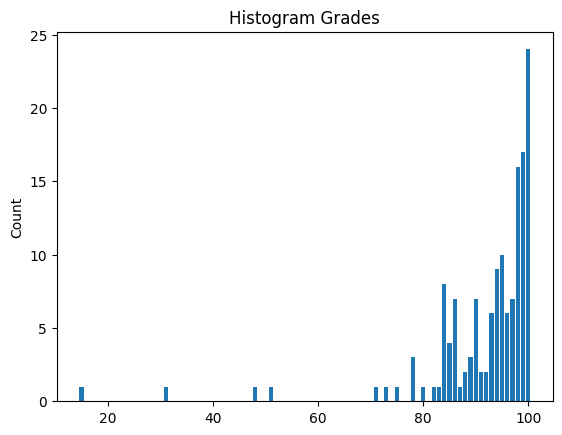

In [56]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [57]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,prompt_avg_words,response_avg_words,whitelist_score,blacklist_score,average_sentiment,bert_average_sentiment,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,automated_readability_index,coleman_liau_index,linsear_write_formula,dale_chall_readability_score
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.322617,26.255108,0.846522,1.781713,0.139457,-0.772049,53.983571,9.700000,10.689286,9.214286,12.257143,12.083571,9.912202,10.762143
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.055791,16.578947,0.031328,0.172117,0.130718,-0.709885,53.115556,9.316667,10.090556,4.238889,11.316667,11.445000,7.929960,10.306111
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.053652,3.065649,1.452380,3.555556,-0.021337,-0.777762,55.614444,8.466667,10.252222,2.577778,13.522222,13.424444,10.027778,11.495556
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.017632,13.347445,0.732213,1.483516,0.004042,-0.770788,66.300000,7.365000,8.794500,0.650000,9.255000,9.610000,7.658333,10.251000
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.003110,2.697958,0.144917,0.121121,0.089507,-0.746055,56.105116,8.709302,9.846860,3.055814,14.056977,14.135581,7.978654,10.773023


#### Merging scores with features

In [58]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,prompt_avg_words,response_avg_words,whitelist_score,blacklist_score,average_sentiment,bert_average_sentiment,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,automated_readability_index,coleman_liau_index,linsear_write_formula,dale_chall_readability_score,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.322617,26.255108,0.846522,1.781713,0.139457,-0.772049,53.983571,9.700000,10.689286,9.214286,12.257143,12.083571,9.912202,10.762143,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.055791,16.578947,0.031328,0.172117,0.130718,-0.709885,53.115556,9.316667,10.090556,4.238889,11.316667,11.445000,7.929960,10.306111,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.053652,3.065649,1.452380,3.555556,-0.021337,-0.777762,55.614444,8.466667,10.252222,2.577778,13.522222,13.424444,10.027778,11.495556,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.017632,13.347445,0.732213,1.483516,0.004042,-0.770788,66.300000,7.365000,8.794500,0.650000,9.255000,9.610000,7.658333,10.251000,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.003110,2.697958,0.144917,0.121121,0.089507,-0.746055,56.105116,8.709302,9.846860,3.055814,14.056977,14.135581,7.978654,10.773023,100.0


In [59]:
# Removing outliers

# Calculate Q1, Q3, and IQR
Q1 = temp_df['grade'].quantile(0.25)
Q3 = temp_df['grade'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data frame to remove outliers
temp_df = temp_df[(temp_df['grade'] >= lower_bound) & (temp_df['grade'] <= upper_bound)]

X = temp_df[temp_df.columns[1:-1]]
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(116, 15) (116,)


C:\Users\salih\AppData\Local\Temp\ipykernel_3008\146312205.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = temp_df.corr()


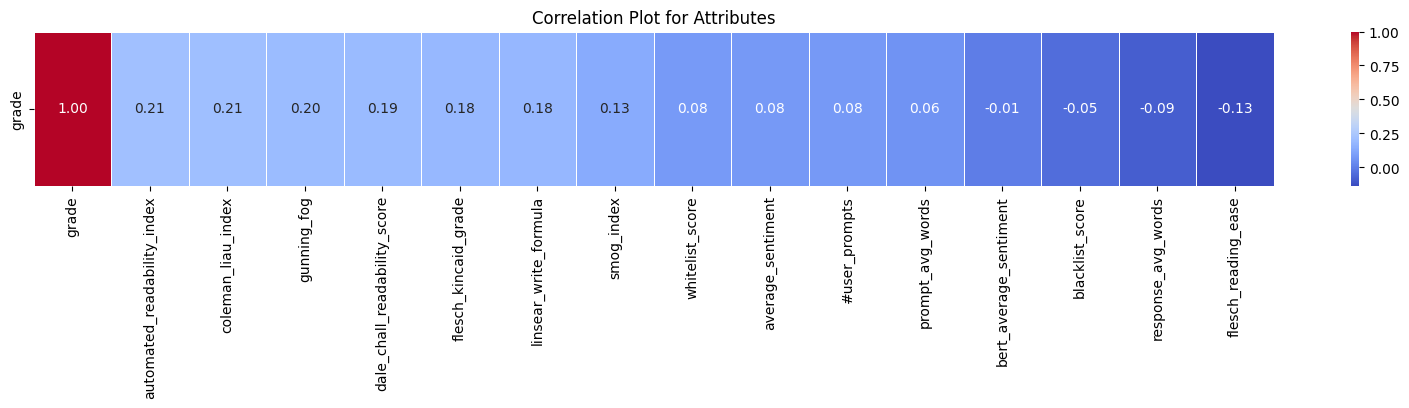

In [60]:
import seaborn as sns
# Correlation plot for feature subset selection

# Calculating the correlation matrix
correlation_matrix = temp_df.corr()

corr_with_target = correlation_matrix[['grade']].sort_values(by='grade', ascending=False)

fig, ax = plt.subplots()
plt.title('Correlation Plot for Attributes')
fig.set_size_inches(20,2)
sns.heatmap(corr_with_target.T, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

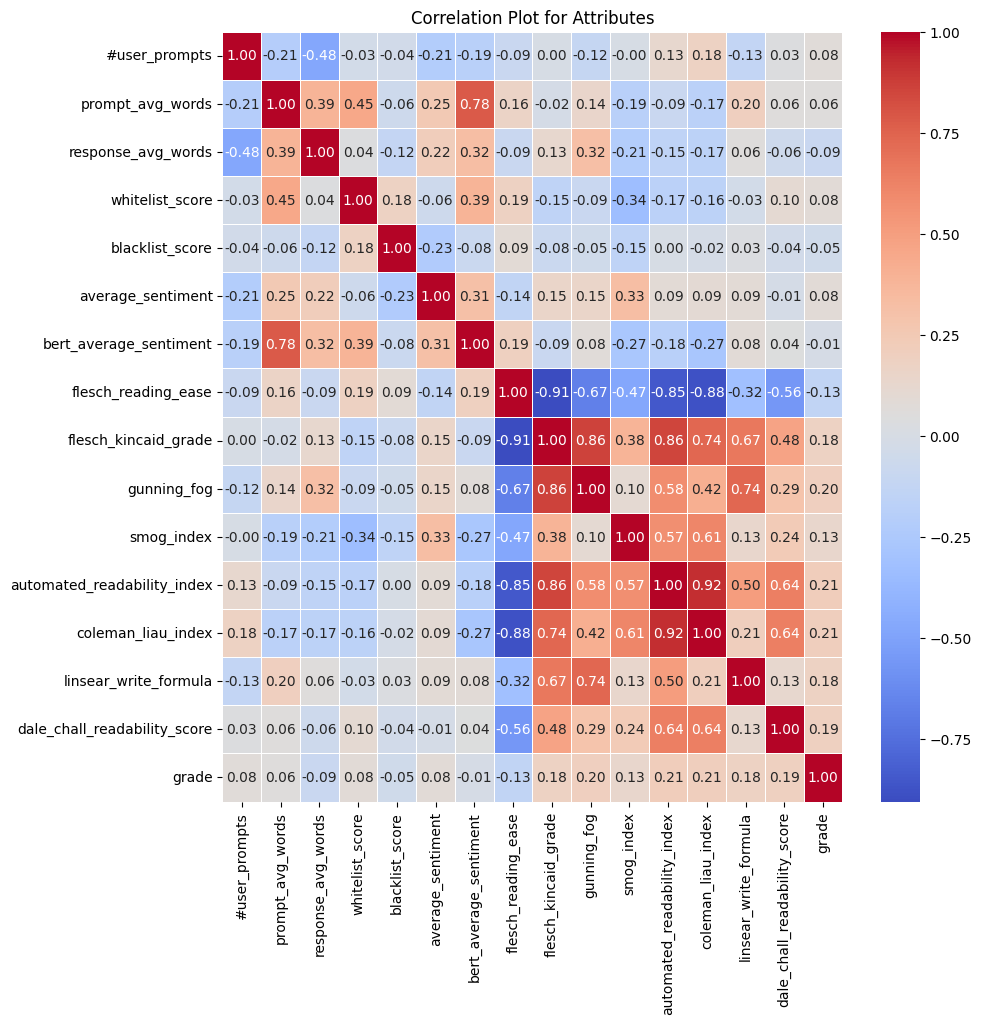

In [61]:
fig, ax = plt.subplots()
plt.title('Correlation Plot for Attributes')
fig.set_size_inches(10,10)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

We eliminate the features with the least correlation with grade & most correlation with other features (they both do not contribute to the information about target and carrying similar information to other features).

In [79]:
subset_of_features = ["average_sentiment", "linsear_write_formula", "flesch_kincaid_grade", "smog_index",
                       "dale_chall_readability_score", "automated_readability_index"]

X = temp_df[subset_of_features]
X = temp_df[temp_df.columns[1:-1]]

In [80]:
print(X.columns)

Index(['#user_prompts', 'prompt_avg_words', 'response_avg_words',
       'whitelist_score', 'blacklist_score', 'average_sentiment',
       'bert_average_sentiment', 'flesch_reading_ease', 'flesch_kincaid_grade',
       'gunning_fog', 'smog_index', 'automated_readability_index',
       'coleman_liau_index', 'linsear_write_formula',
       'dale_chall_readability_score'],
      dtype='object')


-------------------------------------------------- RUN TILL HERE FOR CHALLENGE PART -----------------------------------------------

#### Train/Test split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 92
Test set size: 24


In [82]:
from sklearn.linear_model import Lasso
from mlxtend.feature_selection import SequentialFeatureSelector


# Define the forward selection model
forward_selector = SequentialFeatureSelector(Lasso(),
                                             k_features='best',
                                             forward=False,
                                             scoring='neg_mean_squared_error', 
                                             cv=5)

# Fit the forward selection model
forward_selector = forward_selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[list(forward_selector.k_feature_idx_)]
print(selected_features)

Index(['whitelist_score', 'blacklist_score', 'average_sentiment',
       'bert_average_sentiment', 'flesch_reading_ease', 'flesch_kincaid_grade',
       'gunning_fog', 'coleman_liau_index'],
      dtype='object')


In [98]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [99]:
X_train.columns

Index(['whitelist_score', 'blacklist_score', 'average_sentiment',
       'bert_average_sentiment', 'flesch_reading_ease', 'flesch_kincaid_grade',
       'gunning_fog', 'coleman_liau_index'],
      dtype='object')

#### Fitting a model

#### Predicting and Analyzing 

In [270]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [100]:
# Grid Search for Lasso Regression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'max_iter': [1000, 2000, 3000],
              'tol': [0.0001, 0.001, 0.01, 0.1]}

# Create a Lasso object
lasso = Lasso()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

print(best_parameters)

{'alpha': 0.3, 'max_iter': 1000, 'tol': 0.0001}


In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Assume X is your feature set and y is your target variable
# Also assume that you have already split your data into training and test sets

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rf = RandomForestRegressor(criterion='squared_error')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(best_params)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


In [102]:
# Train a Random Forest Regressor with the best parameters
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=200, criterion='squared_error', bootstrap= True, max_depth= 10, min_samples_leaf= 4, min_samples_split= 5)
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)

In [72]:
# Train a Linear Regression model
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [277]:
# Train a Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(random_state=0, criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', max_depth=10,
                          random_state=0)

In [283]:
# Train a Support Vector Regressor
from sklearn.svm import SVR

regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)

SVR(kernel='linear')

In [285]:
# Train a KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [307]:
# Train a Polynomial Regressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
regressor = LinearRegression()
regressor.fit(X_poly, y_train)

LinearRegression()

In [106]:
# Train a Lasso Regressor
from sklearn.linear_model import Lasso

regressor = Lasso(alpha=0.3, max_iter=1000, tol=0.0001, warm_start=False, selection='random')
regressor.fit(X_train, y_train)

Lasso(alpha=0.3, selection='random')

In [182]:
# Train a Ridge Regressor
from sklearn.linear_model import Ridge

regressor = Ridge(alpha=0.1, max_iter=3000, tol=0.001)
regressor.fit(X_train, y_train)

Ridge(alpha=0.1, max_iter=3000, tol=0.001)

In [178]:
# Train a Bayesian Ridge Regressor
from sklearn.linear_model import BayesianRidge

regressor = BayesianRidge()
regressor.fit(X_train, y_train)

BayesianRidge()

In [115]:
# Train an AdaBoost Regressor
from sklearn.ensemble import AdaBoostRegressor

regressor = AdaBoostRegressor(n_estimators=100, random_state=0, loss='square', learning_rate=0.1)
regressor.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.1, loss='square', n_estimators=100,
                  random_state=0)

In [271]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 39.05251244907231
Node 1 has MSE 69.86776859504243
Node 2 has MSE 38.20408163265165
Node 3 has MSE 7.25
Node 4 has MSE 1.0
Node 5 has MSE 0.0
Node 6 has MSE 0.0
Node 7 has MSE 1.0
Node 8 has MSE 0.0
Node 9 has MSE 0.0
Node 10 has MSE 8.222222222221717
Node 11 has MSE 2.25
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 0.0
Node 15 has MSE 1.1875
Node 16 has MSE 0.22222222222080745
Node 17 has MSE 0.0
Node 18 has MSE 0.0
Node 19 has MSE 0.0
Node 20 has MSE 26.458121643201594
Node 21 has MSE 34.97633136094737
Node 22 has MSE 34.51555555555569
Node 23 has MSE 15.58333333333394
Node 24 has MSE 0.0
Node 25 has MSE 0.6875
Node 26 has MSE 0.25
Node 27 has MSE 0.0
Node 28 has MSE 0.0
Node 29 has MSE 0.0
Node 30 has MSE 19.728395061727497
Node 31 has MSE 5.836734693877588
Node 32 has MSE 0.0
Node 33 has MSE 2.2222222222226264
Node 34 has MSE 1.25
Node 35 has MSE 0.25
Node 36 has MSE 0.0
Node 37 has MSE 0.0
Node 38 has MSE 0.25
Node 39 has MSE 0.0
Node 40 has MSE 0.0
Node 

In [260]:
# # Plotting the Tree 
# import graphviz
# dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
# graph = graphviz.Source(dot_data)
# graph.render("hw")

In [107]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 29.934941136343795
MSE TEST: 36.849078521875434
R2 Train: 0.14609954914392753
R2 TEST: 0.012557840027901945


In [108]:
# Bagging (for overfit models)

from sklearn.ensemble import BaggingRegressor

# Create a BaggingRegressor object
bagging = BaggingRegressor(base_estimator=regressor, n_estimators=20, random_state=0)

# Fit the model
bagging.fit(X_train, y_train)

# Make predictions
y_train_pred = bagging.predict(X_train)
y_test_pred = bagging.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 30.033576381020026
MSE TEST: 36.930769900535644
R2 Train: 0.14328595817958523
R2 TEST: 0.010368761911675795


c:\Users\salih\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [109]:
# Boosting (for underfit models)

from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(base_estimator=regressor, n_estimators=100)

# Fit the model
ada.fit(X_train, y_train)

# Make predictions
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 31.21444442094311
MSE TEST: 34.247579443429615
R2 Train: 0.10960145059698556
R2 TEST: 0.0822700274754381


c:\Users\salih\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


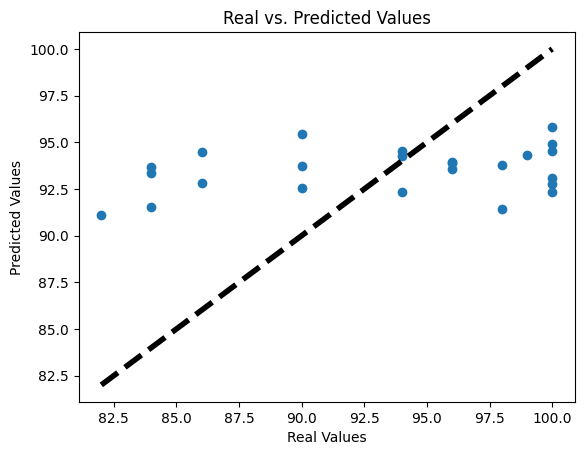

In [110]:
import matplotlib.pyplot as plt

# Assume y_test are your real values and y_pred are your predicted values

# Create a scatter plot of the real vs. predicted values
plt.scatter(y_test, y_test_pred)


# Create a line representing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# Set the labels for the x and y axes
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')

# Set the title of the plot
plt.title('Real vs. Predicted Values')

# Show the plot
plt.show()